> # Model Optimization

In [93]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
# from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE

import category_encoders as ce
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from scipy.stats import mannwhitneyu

import pingouin as pg

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve, make_scorer
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle


> # Event
- C – Closest approach to a coast, not followed by a landfall
- G – Genesis
- I – An intensity peak in terms of both pressure and wind
- L – Landfall (center of system crossing a coastline)
- P – Minimum in central pressure
- R – Provides additional detail on the intensity of the cyclone when rapid changes are underway
- S – Change of status of the system
- T – Provides additional detail on the track (position) of the cyclone
- W – Maximum sustained wind speed


> # Status
- TD – Tropical cyclone of tropical depression intensity (< 34 knots)
- TS – Tropical cyclone of tropical storm intensity (34-63 knots)
- HU – Tropical cyclone of hurricane intensity (> 64 knots)
- EX – Extratropical cyclone (of any intensity)
- SD – Subtropical cyclone of subtropical depression intensity (< 34 knots)
- SS – Subtropical cyclone of subtropical storm intensity (> 34 knots)
- LO – A low that is neither a tropical cyclone, a subtropical cyclone, nor an extratropical cyclone (of any intensity)
- WV – Tropical Wave (of any intensity)
- DB – Disturbance (of any intensity)

In [94]:
pacific= pd.read_csv('Pacific_for_Modelling.csv').set_index('Unnamed: 0')

In [97]:
X =pacific[['Latitude', 
       'Longitude',  'Maximum Wind', 'Minimum Pressure',
       'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW',
       'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW',
       'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW',
       'High Wind NW' , 'Month' , 'Year']]
y= pacific['Status']

base model

In [98]:
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
xgb = XGBClassifier()
smote = SMOTE()

Data splitting

In [99]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=.2, random_state=2020)

## We will be using recall as metric because in this case false negatives are more catastrophic than the false positives

> # Feature Selection

In [100]:
rfc.fit(X_train_val , y_train_val)
features = pd.Series(rfc.feature_importances_ , index= X_train_val.columns).sort_values(ascending=False)
features

Maximum Wind        0.659970
Minimum Pressure    0.104198
Latitude            0.037507
Year                0.036120
Longitude           0.035351
Low Wind NE         0.021433
Low Wind NW         0.020478
Low Wind SE         0.015164
Month               0.011219
Low Wind SW         0.010939
High Wind NE        0.009806
High Wind SE        0.008919
Moderate Wind NE    0.007733
High Wind SW        0.006126
High Wind NW        0.006102
Moderate Wind SW    0.003791
Moderate Wind NW    0.003034
Moderate Wind SE    0.002111
dtype: float64

In [101]:
features.index[:5]

Index(['Maximum Wind', 'Minimum Pressure', 'Latitude', 'Year', 'Longitude'], dtype='object')

In [102]:
X_sel = pacific[features.index[:5]]
y = pacific['Status']

In [103]:
X_train_val_sel, X_test_sel, y_train_val, y_test = train_test_split(X_sel,y,test_size=.2, random_state=2020)

In [104]:
rskf = RepeatedStratifiedKFold(n_splits=5, random_state=2020)

rfc_score = cross_validate(rfc, X_train_val_sel, y_train_val, scoring=make_scorer(recall_score, average='weighted'), cv=rskf, n_jobs=-1, verbose=1)
dtc_score = cross_validate(dtc, X_train_val_sel, y_train_val, scoring=make_scorer(recall_score, average='weighted'), cv=rskf, n_jobs=-1, verbose=1)
xgb_score = cross_validate(xgb, X_train_val_sel, y_train_val, scoring=make_scorer(recall_score, average='weighted'), cv=rskf, n_jobs=-1, verbose=1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


In [105]:
print('Random forest Score is' , rfc_score['test_score'].mean())
print('Decision Tree Score is', dtc_score['test_score'].mean())
print('XGbooster Score is', xgb_score['test_score'].mean())


Random forest Score is 0.9804151480742687
Decision Tree Score is 0.9723611882727435
XGbooster Score is 0.9791668945770595


## in this case Random Forest Classifier has the greatest recall score so we will be using random forest classifier

In [106]:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [107]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rfc_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [108]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
rfc_random = RandomizedSearchCV(rfc, param_distributions=rfc_params, scoring=make_scorer(recall_score, average='weighted'), cv=skf, verbose=1, n_jobs=-1)
rfc_random.fit(X_train_val_sel, y_train_val)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring=make_scorer(recall_score, average=weighted),
                   verbose=1)

In [109]:
rfc_tuned = rfc_random.best_estimator_
rfc_tuned_score = cross_val_score(rfc_tuned, X_train_val_sel, y_train_val, scoring=make_scorer(recall_score, average='weighted'), cv=rskf, n_jobs=-1, verbose=1)
rfc_tuned_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


array([0.98278336, 0.97919656, 0.98254424, 0.98278336, 0.97847405,
       0.98134864, 0.98158776, 0.98110952, 0.98158776, 0.98062664,
       0.97824008, 0.98134864, 0.98278336, 0.98373984, 0.97990911,
       0.97704448, 0.982066  , 0.98350072, 0.98254424, 0.98277924,
       0.98350072, 0.9796748 , 0.98158776, 0.98302248, 0.98134418,
       0.97824008, 0.97919656, 0.98302248, 0.9808704 , 0.98445348,
       0.98134864, 0.98182688, 0.98182688, 0.98230512, 0.98254006,
       0.9796748 , 0.98278336, 0.9808704 , 0.97800096, 0.98541019,
       0.98134864, 0.98254424, 0.98110952, 0.98230512, 0.97943076,
       0.9832616 , 0.98158776, 0.98421808, 0.98110952, 0.98038747])

In [110]:
rfc_score_sel['test_score'].mean()

0.9805251204150405

In [111]:
rfc_tuned_score.mean()

0.9814960083939656

# Comparing benchmark model and tuned model

In [112]:
model_default = rfc.fit(X_train_val_sel, y_train_val)
y_pred_default = model_default.predict(X_test_sel)

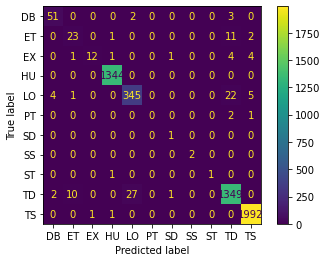

In [125]:
rfc.fit(X_train_val_sel, y_train_val)
plot_confusion_matrix(rfc, X_test_sel, y_test)

In [113]:
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

          DB       0.90      0.95      0.92        56
          ET       0.69      0.65      0.67        37
          EX       1.00      0.61      0.76        23
          HU       1.00      1.00      1.00      1344
          LO       0.92      0.92      0.92       377
          PT       0.00      0.00      0.00         3
          SD       0.33      1.00      0.50         1
          SS       1.00      1.00      1.00         2
          ST       1.00      0.50      0.67         2
          TD       0.97      0.97      0.97      1389
          TS       1.00      1.00      1.00      1994

    accuracy                           0.98      5228
   macro avg       0.80      0.78      0.76      5228
weighted avg       0.98      0.98      0.98      5228



In [114]:
model_tuned = rfc_tuned.fit(X_train_val_sel, y_train_val)
y_pred_tuned = model_tuned.predict(X_test_sel)

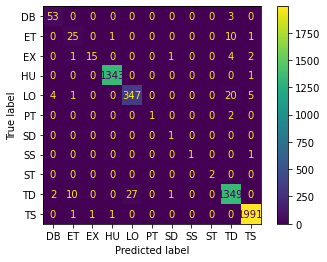

In [126]:
rfc_tuned.fit(X_train_val_sel, y_train_val)
plot_confusion_matrix(rfc_tuned, X_test_sel, y_test)

In [115]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

          DB       0.90      0.95      0.92        56
          ET       0.68      0.68      0.68        37
          EX       0.93      0.61      0.74        23
          HU       1.00      1.00      1.00      1344
          LO       0.93      0.92      0.93       377
          PT       1.00      0.33      0.50         3
          SD       0.33      1.00      0.50         1
          SS       1.00      0.50      0.67         2
          ST       1.00      1.00      1.00         2
          TD       0.97      0.97      0.97      1389
          TS       1.00      1.00      1.00      1994

    accuracy                           0.98      5228
   macro avg       0.88      0.81      0.81      5228
weighted avg       0.98      0.98      0.98      5228



## We can see that tuned model performs  better in terms of accuracy and recall, but no significant increase in Precision, since we will be using Precision Score mainly as metric, we will choose untuned model for less file size,

> # Dumping

In [116]:
rfc.fit(X_sel,y)
filename = 'rfc4.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [117]:
X_train_val_sel

,Maximum Wind,Minimum Pressure,Latitude,Year,Longitude
Unnamed: 0,,,,,
9288,40,995,16.1,1983,128.5
6651,45,995,31.3,1976,115.9
11712,65,994,17.9,1988,115.4
20505,45,1000,17.6,2005,111.7
2027,45,995,25.8,1963,172.2
...,...,...,...,...,...
18523,25,1011,19.8,2001,148.9
11971,110,995,15.4,1988,159.8
14966,50,997,22.2,1993,106.9


In [118]:
# nyoba api

In [119]:
df_to_predict = pd.DataFrame({
            'Maximum Wind': [222],
            'Minimum Pressure': [1222],
            'Year': [2001],
            'Latitude': [16.1],
            'Longitude': [110]
    
        })

#  222 1222 2001 16.1 110

In [122]:
prediksi = rfc.predict_proba(df_to_predict)

In [124]:
prediksi

array([[0.  , 0.02, 0.18, 0.72, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08]])